In [1]:
import geopandas as gpd
from geopy.distance import great_circle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from shapely.geometry import MultiPoint, Point
from sklearn.cluster import DBSCAN
import warnings

# Set default settings.
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [37]:
# Read in data on street trees.
df = pd.read_csv('https://data.cityofnewyork.us/api/views/uvpi-gqnh/rows.csv?accessType=DOWNLOAD')

# Read in geographic data on New York City.
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc.rename(columns={'BoroName': 'bname'}, inplace=True)
nyc_streets = gpd.read_file('./data/data_raw/nyc_streets/geo_export_f311eef5-5969-43eb-a781-39fa54d09b70.shp')

In [6]:
df.head(1)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,address,postcode,zip_city,community board,borocode,borough,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,None,None,NoDamage,TreesCount Staff,None,No,No,No,No,No,No,No,No,No,108-005 70 AVENUE,11375,Forest Hills,406,4,Queens,29,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09


In [ ]:
# Exploratory data anaylsis with Pandas Profiling.
prfl = ProfileReport(df.loc[:, 'tree_id':'bbl'], title='Fast EDA', explorative=True)
prfl.to_notebook_iframe()

In [ ]:
# Save profile report as .html file for easy access.
prfl.to_file('eda_trees_report.html')

# Inspecting distribution of data

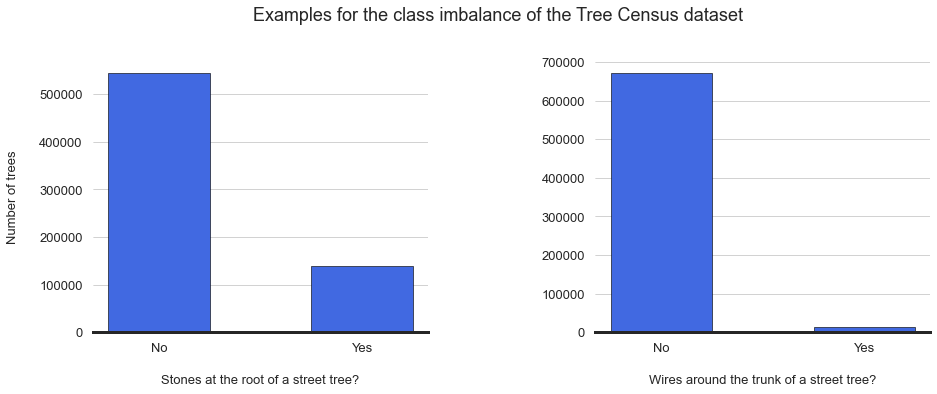

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

fig.suptitle('Examples for the class imbalance of the Tree Census dataset', fontsize=18, y=1.03)

fig.subplots_adjust(wspace=0.5)

# Plot distribution of data on stones at the root of street trees.
fig_a = df['root_stone'].hist(ax=axs[0],
                              align='left',
                              bins=np.arange(3),
                              rwidth=0.5,
                              grid=False,
                              color='royalblue',
                              edgecolor='k',
                              linewidth=0.6)
fig_a.spines['bottom'].set_linewidth(3)
fig_a.set_ylabel('Number of trees', fontdict={'fontsize': 13}, labelpad=20)
fig_a.grid(axis='y', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
fig_a.set_xlabel('Stones at the root of a street tree?', fontdict={'fontsize': 13}, labelpad=20)
fig_a.tick_params(axis='both', which='major', labelsize=13)

# Plot distribution of data on wires around the trunk of street trees.
fig_b = df['trunk_wire'].hist(ax=axs[1],
                              align='left',
                              bins=np.arange(3),
                              rwidth=0.5,
                              grid=False,
                              color='royalblue',
                              edgecolor='k',
                              linewidth=0.6)
fig_b.spines['bottom'].set_linewidth(3)
fig_b.grid(axis='y', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
fig_b.set_xlabel('Wires around the trunk of a street tree?', fontdict={'fontsize': 13}, labelpad=20)
fig_b.tick_params(axis='both', which='major', labelsize=13)

# Inspecting specific columns

### Tree diameter

In [8]:
# Inspect data on tree diameters.
df['tree_dbh'].describe()

count    683788.000000
mean         11.279787
std           8.723042
min           0.000000
25%           4.000000
50%           9.000000
75%          16.000000
max         450.000000
Name: tree_dbh, dtype: float64

Text(0.5, 0, 'Diameter')

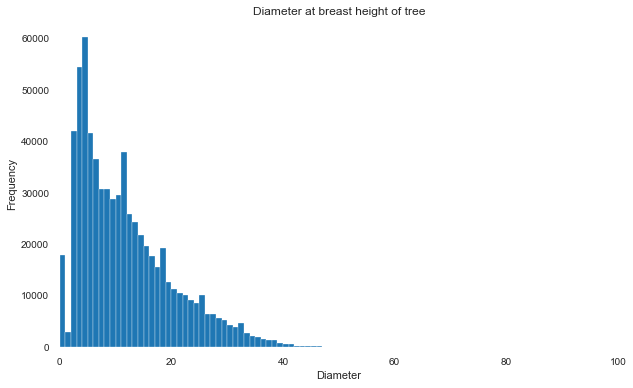

In [9]:
# Visualize the distribution of the data on the diameter of street trees.
df['tree_dbh'] \
    .plot(bins=450, figsize=(10, 6), kind='hist', title='Diameter at breast height of tree', xlim=(0, 100)) \
    .set_xlabel('Diameter')

### Tree species

In [10]:
df['spc_latin'].describe()

count                    652169
unique                      132
top       Platanus x acerifolia
freq                      87014
Name: spc_latin, dtype: object

In [11]:
df['spc_latin'].isna().any()

True

In [12]:
len(df.loc[df['spc_latin'].isna()])

31619

In [13]:
len(df.loc[df['health'].isna()])

31616

In [14]:
df.loc[df['spc_latin'].isna()]

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,address,postcode,zip_city,community board,borocode,borough,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
37,211205,302080,09/09/2015,0,16,OnCurb,Stump,NaN,NaN,NaN,NaN,NaN,NaN,TreesCount Staff,NaN,No,No,No,No,No,No,No,No,No,21-023 24 DRIVE,11102,Astoria,401,4,Queens,22,36,12,QN72,Steinway,4009500,New York,40.774993,-73.922037,1.005843e+06,221637.1447,22.0,95.0,4019192.0,4.008740e+09
56,187807,506266,08/29/2015,0,0,OnCurb,Dead,NaN,NaN,NaN,NaN,NaN,NaN,Volunteer,NaN,No,No,No,No,No,No,No,No,No,300 EAST MOSHOLU PARKWAY SOUTH,10458,Bronx,207,2,Bronx,11,80,36,BX43,Norwood,2042500,New York,40.871927,-73.882349,1.016788e+06,256965.9677,11.0,415.0,2016979.0,2.032990e+09
196,208322,222858,09/07/2015,10,0,OnCurb,Dead,NaN,NaN,NaN,NaN,NaN,NaN,Volunteer,NaN,No,No,No,No,No,No,No,No,No,1691 DEKALB AVENUE,11237,Brooklyn,304,3,Brooklyn,37,53,18,BK77,Bushwick North,3044500,New York,40.705742,-73.917849,1.007027e+06,196407.8326,37.0,445.0,3073739.0,3.032390e+09
209,209058,415850,09/08/2015,6,0,OnCurb,Dead,NaN,NaN,NaN,NaN,NaN,NaN,TreesCount Staff,NaN,No,No,No,No,No,No,No,No,No,295 ROMA AVENUE,10306,Staten Island,503,5,Staten Island,50,64,24,SI25,Oakwood-Oakwood Beach,5012806,New York,40.559061,-74.106038,9.547857e+05,142975.3788,50.0,12806.0,5056700.0,5.040740e+09
265,210544,216081,09/08/2015,6,0,OnCurb,Dead,NaN,NaN,NaN,NaN,NaN,NaN,Volunteer,NaN,No,No,No,No,No,No,No,No,No,111 DIAMOND STREET,11222,Brooklyn,301,3,Brooklyn,33,50,26,BK76,Greenpoint,3057100,New York,40.726271,-73.947287,9.988606e+05,203881.2130,33.0,571.0,3066265.0,3.026510e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683693,156162,108193,08/18/2015,3,0,OffsetFromCurb,Dead,NaN,NaN,NaN,NaN,NaN,NaN,Volunteer,NaN,No,No,No,No,No,No,No,No,No,156 EAST 95 STREET,10128,New York,108,1,Manhattan,5,68,28,MN40,Upper East Side-Carnegie Hill,1015801,New York,40.785136,-73.951108,9.977894e+05,225326.7807,5.0,15801.0,1048443.0,1.015230e+09
683695,170888,231931,08/24/2015,0,5,OnCurb,Stump,NaN,NaN,NaN,NaN,NaN,NaN,TreesCount Staff,NaN,No,No,No,No,No,No,No,No,No,2327 BEDFORD AVENUE,11226,Brooklyn,317,3,Brooklyn,40,42,21,BK95,Erasmus,3079400,New York,40.647154,-73.955619,9.965658e+05,175055.1250,40.0,794.0,3117748.0,3.051270e+09
683697,177922,410634,08/26/2015,0,17,OnCurb,Stump,NaN,NaN,NaN,NaN,NaN,NaN,Volunteer,NaN,No,No,No,No,No,No,No,No,No,419 HOLDRIDGE AVENUE,10312,Staten Island,503,5,Staten Island,51,62,24,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5017600,New York,40.528544,-74.165246,9.383125e+05,131882.7120,51.0,176.0,5081744.0,5.063570e+09
683698,193791,208850,09/01/2015,3,0,OnCurb,Dead,NaN,NaN,NaN,NaN,NaN,NaN,TreesCount Staff,NaN,No,No,No,No,No,No,No,No,No,140 STRYKER STREET,11223,Brooklyn,315,3,Brooklyn,47,45,22,BK26,Gravesend,3038600,New York,40.590385,-73.972892,9.917788e+05,154370.9206,47.0,386.0,3194400.0,3.071730e+09


In [15]:
df.loc[(df['spc_latin'].isna()) & (~df['health'].isna())]

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,address,postcode,zip_city,community board,borocode,borough,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
356532,562532,315837,05/19/2016,4,0,OnCurb,Alive,Good,NaN,NaN,1or2,None,NoDamage,TreesCount Staff,Stones,Yes,No,No,No,No,No,No,No,No,157-021 12 AVENUE,11357,Whitestone,407,4,Queens,19,26,11,QN49,Whitestone,4099100,New York,40.791332,-73.803610,1038630.469,227641.3712,19.0,991.0,4103675.0,4.045570e+09
427537,630814,323764,07/18/2016,11,0,OnCurb,Alive,Poor,NaN,NaN,None,NaN,Damage,TreesCount Staff,NaN,No,No,No,No,No,No,No,No,No,38-028 CEDAR LANE,11363,Little Neck,411,4,Queens,19,26,11,QN45,Douglas Manor-Douglaston-Little Neck,4148300,New York,40.771945,-73.750414,1053380.635,220615.7964,19.0,1483.0,4168471.0,4.080630e+09
431405,651014,308540,08/02/2016,40,0,OnCurb,Alive,Good,NaN,NaN,None,None,Damage,TreesCount Staff,Stones,Yes,No,No,No,No,No,No,No,No,81-015 91 AVENUE,11421,Woodhaven,409,4,Queens,32,38,15,QN53,Woodhaven,4000800,New York,40.686902,-73.859411,1023240.372,189564.7945,32.0,8.0,4185286.0,4.089630e+09
608574,47941,346795,07/03/2015,5,0,OnCurb,Alive,Good,NaN,NaN,1or2,None,NoDamage,NYC Parks Staff,None,No,No,No,No,No,No,No,No,No,61-032 78 STREET,11379,Middle Village,405,4,Queens,30,30,15,QN21,Middle Village,4067100,New York,40.723484,-73.880296,1017429.853,202884.0907,30.0,671.0,4067282.0,4.029350e+09
656953,150745,515014,08/16/2015,3,0,OnCurb,Alive,Good,NaN,NaN,1or2,None,Damage,Volunteer,None,No,No,No,No,No,No,No,No,No,662 EAST 234 STREET,10466,Bronx,212,2,Bronx,11,81,36,BX44,Williamsbridge-Olinville,2042000,New York,40.894521,-73.858255,1023438.408,265207.8056,11.0,420.0,2068064.0,2.049940e+09


In [ ]:
# Finding: Tree species where the value is missing are mostly dead or stump trees with few (n = 5) exceptions.

# Inspecting missing values

In [16]:
# Replace NaN values in features with entries signalling this tree is either dead or a stump.
df['steward'].fillna('Dead|Stump', inplace=True)
df['guards'].fillna('Dead|Stump', inplace=True)
df['sidewalk'].fillna('Dead|Stump', inplace=True)

# In 'steward', replace spectrum of answers to yes (= alive) or no (= dead/stump).
df['steward'].replace(['1or2', '3or4', '4orMore', 'None'], 'Alive', inplace=True)

# Replace NaN values in the target with entries signalling this tree is either dead or a stump.
df['health'].fillna('Dead|Stump', inplace=True)

# Geographic analysis

In [39]:
# Bring geographic data on boroughs and street trees in NYC into a new format.
trees = gpd.GeoDataFrame(df, geometry=[Point(coordinates) for coordinates in zip(df['longitude'], df['latitude'])])
trees.crs = {'init': 'epsg:4326', 'no_defs': True}
nyc = nyc.to_crs(epsg=4326)
nyc.crs = {'init': 'epsg:4326', 'no_defs': True}

In [40]:
# Prepare geographic data on trees and boroughs in NYC.
trees_grouped = trees.groupby('borough').count()['tree_id']
trees_per_borough = nyc.merge(trees_grouped, left_on='bname', right_index=True)
tree_counts_borough = trees_per_borough[['bname', 'tree_id']].sort_values('tree_id')

# Question: Which borough of New York has the most street trees?

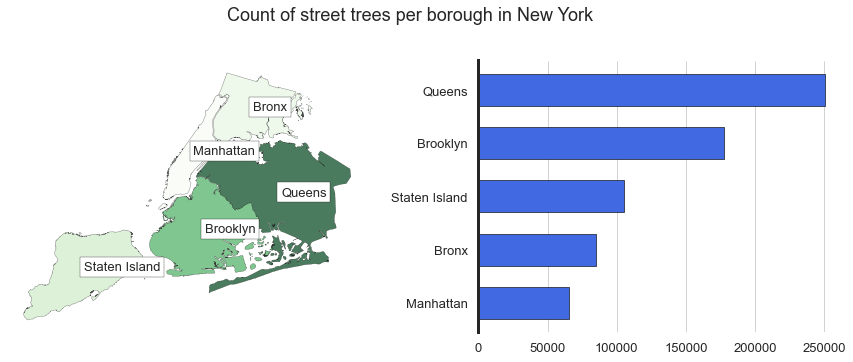

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

fig.suptitle('Count of street trees per borough in New York', fontsize=18, y=1.03)

fig.subplots_adjust(wspace=0.3)

# Plot chloropleth of count of street trees per NYC borough.
fig1 = trees_per_borough.plot(ax=axs[0],
                              column='tree_id',
                              alpha=0.7,
                              cmap='Greens',
                              edgecolor='k',
                              linewidth=0.3)

axs[0].axis('off')

# Add names of NYC Boroughs to the center of each polygon.
for borough in trees_per_borough.itertuples(index=True, name='bname'):
    axs[0].text(borough.geometry.centroid.x,
                borough.geometry.centroid.y,
                borough.bname,
                fontsize=13,
                bbox={
                  'boxstyle': 'square, pad=0.3',
                  'edgecolor': 'k',
                  'facecolor': 'white'
                  })

# Create a horizontal barchart for the number of trees per NYC borough.
fig2 = tree_counts_borough['tree_id'].plot(ax=axs[1],
                                           kind='barh',
                                           color='royalblue',
                                           width=0.6,
                                           edgecolor='k',
                                           linewidth=0.6)
fig2.set_yticklabels(tree_counts_borough['bname'])
fig2.spines['left'].set_linewidth(3)
fig2.grid(axis='x', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
fig2.tick_params(axis='both', which='major', labelsize=13)

# Question: Which borough has the most diverse street tree flora?

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

fig.suptitle('Count of tree species per borough in New York', fontsize=18, y=1.03)

fig.subplots_adjust(wspace=0.3)

# Determine the number of street tree species per borough.
trees_species_grouped = trees.groupby(['borough', 'spc_common']) \
                             .count()[['tree_id']] \
                             .sort_values(['borough', 'tree_id'], 
                                          ascending=False)

tree_species_count_per_borough = pd.Series([len(trees_species_grouped.loc['Bronx']),
                                            len(trees_species_grouped.loc['Brooklyn']),
                                            len(trees_species_grouped.loc['Manhattan']),
                                            len(trees_species_grouped.loc['Staten Island']),
                                            len(trees_species_grouped.loc['Queens'])],
                                          index=['Bronx', 'Brooklyn', 'Manhattan', 'Staten Island', 'Queens']) \
                                    .sort_values()

tree_species_count_per_borough.name = 'species_count'

trees_species_grouped_per_borough = nyc.merge(tree_species_count_per_borough,
                                              left_on='bname',
                                              right_index=True)

# Plot chloropleth of count of street tree species of each NYC borough.
fig3 = trees_species_grouped_per_borough.plot(ax=axs[0],
                                              column='species_count',
                                              alpha=0.7,
                                              cmap='summer_r',
                                              edgecolor='k',
                                              linewidth=0.3)
axs[0].axis('off')
# Add names of NYC Boroughs to the center of each polygon.
for borough in trees_per_borough.itertuples(index=True, name='bname'):
    axs[0].text(borough.geometry.centroid.x,
                borough.geometry.centroid.y,
                borough.bname,
                fontsize=13,
                bbox={
                  'boxstyle': 'square, pad=0.3',
                  'edgecolor': 'k',
                  'facecolor': 'white'
                  })

# Create a horizontal barchart for the number of tree species per borough in NYC.
fig4 = tree_species_count_per_borough.plot(ax=axs[1],
                                           kind='barh',
                                           color='royalblue',
                                           width=0.6,
                                           edgecolor='k',
                                           linewidth=0.6)

# Set other subplot settings.
fig4.set_yticklabels(tree_species_count_per_borough.index, fontdict={'fontsize': 13}, rotation=360)
fig4.spines['left'].set_linewidth(3)
fig4.grid(axis='x', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
fig4.tick_params(axis='both', which='major', labelsize=13)

# Question: In which condition are most of New York's street trees?

In [ ]:
# Find health condition of street trees per borough.
trees_health_count = trees.groupby('health').count()['tree_id'].sort_values(ascending=False)

# Find unhealthy street trees per borough.
trees_grouped_unhealthy = trees.loc[(trees['health']=='Fair') |
                                    (trees['health']=='Dead|Stump') |
                                    (trees['health']=='Poor')] \
                               .groupby('borough') \
                               .count()['tree_id'] \
                               .sort_values()

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

fig.subplots_adjust(wspace=0.2)

# Plot count of streets in their respective health condition.
fig5 = trees_health_count.plot(ax=axs[0],
                               kind='bar',
                               color='royalblue', 
                               width=0.6,
                               edgecolor='k',
                               linewidth=0.6)

# Set other plot settings.
fig5.set_title('Health condition of street trees in New York', fontsize=18, pad=20)
fig5.set_xticklabels(trees_health_count.index, fontdict={'fontsize': 13}, rotation=360)
fig5.set_xlabel('')
fig5.set_ylabel('Number of trees', fontdict={'fontsize': 13}, labelpad=20)
fig5.spines['bottom'].set_linewidth(3)
fig5.grid(axis='y', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
fig5.tick_params(axis='both', which='major', labelsize=13)

# Visualize count of trees in an unhealthy condition per borough.
fig6 = trees_grouped_unhealthy.plot(ax=axs[1],
                                    kind='bar',
                                    color='royalblue', 
                                    width=0.6,
                                    edgecolor='k',
                                    linewidth=0.6)

# Set other plot settings.
fig6.set_title('Count of unhealthy (i.e., not good) trees per borough', fontsize=18, pad=20)
fig6.set_xticklabels(trees_grouped_unhealthy.index, fontdict={'fontsize': 13}, rotation=360)
fig6.set_xlabel('')
fig6.set_ylabel('')
fig6.spines['bottom'].set_linewidth(3)
fig6.grid(axis='y', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
fig6.tick_params(axis='both', which='major', labelsize=13)

# Question: Which street trees might need to be removed?

In [ ]:
# Filter for dead / stump trees.
dead_trees = trees.loc[trees['health'] == 'Dead|Stump']
dead_trees_locations = dead_trees[['latitude', 'longitude']].values

# Find clusters of dead / stump street trees in New York.
distance_earth_radius = 0.5 / 6371.0
db = DBSCAN(eps=distance_earth_radius,
            min_samples=1,
            algorithm='ball_tree',
            metric='haversine',
            n_jobs=-1).fit(np.radians(dead_trees_locations))
n_clusters = len(set(db.labels_))
clusters = pd.Series([dead_trees_locations[db.labels_ == n] for n in range(n_clusters)])

def get_centermost_point(cluster):
    """
    Finds the centroid of a cluster of points.
    
    Method adapted from author: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/.
    
    :param cluster: pandas.core.series.Series: Pairs of geographic coordinates in WGS 84.

    :return: pandas.core.series.Series
    """
    
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    centermost_point_coords = tuple(centermost_point)
    
    return centermost_point_coords

clusters_centers = clusters.map(get_centermost_point)

# Plot clusters.
fig, ax = plt.subplots(figsize=(10, 7))
fig.canvas.header_visible = False
ax.axis('off')
ax.set_title('{} dead / stump street tree clusters in New York'.format(n_clusters),
              fontdict={'fontsize': 25})

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colorspectrum = [plt.cm.tab20(each) for each in np.linspace(0, 1, n_clusters)]
for k, col in zip(set(db.labels_), colorspectrum):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (db.labels_ == k)

    xy = dead_trees_locations[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)

    xy = dead_trees_locations[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

# Plot boroughs of NYC for context as well.
nyc.plot(alpha=0.2, ax=ax, color='grey', edgecolor='k')
for borough in nyc.itertuples(index=True, name='bname'):
    plt.text(borough.geometry.centroid.x,
             borough.geometry.centroid.y,
             borough.bname, 
             bbox=dict(boxstyle='square, pad=0.3',
                       edgecolor='k',
                       facecolor='white'))

# Prepare dataset for next step

In [ ]:
# Remove irrelevant columns.
df.drop(['block_id',
         'created_at',
         'tree_dbh',
         'stump_diam',
         'curb_loc',
         'spc_latin',
         'spc_common',
         'user_type',
         'problems',
         'address',
         'postcode',
         'zip_city',
         'community board',
         'borocode',
         'borough',
         'cncldist',
         'st_assem',
         'st_senate',
         'nta',
         'nta_name',
         'boro_ct',
         'state',
         'x_sp',
         'y_sp',
         'council district',
         'census tract',
         'bin',
         'bbl'],
         axis=1,
         inplace=True)

In [ ]:
df.to_csv('./data/data_eda/data.csv.gz', compression='gzip', index=False)